In [1]:
%pylab inline
import scipy
from scipy.sparse import coo_matrix, csr_matrix, block_diag, identity, hstack
import matplotlib.pyplot as plt
from pyiga import bspline, vform, geometry, vis, solvers, utils, topology
from pyiga import assemble
from sksparse.cholmod import cholesky

from pyiga import bspline
from pyiga import utils
from pyiga.bspline import BSplineFunc
from pyiga.tensor import apply_tprod
from pyiga import adaptive as adap

import functools
import itertools

numpy.set_printoptions(linewidth=100000)
numpy.set_printoptions(precision=5)

Populating the interactive namespace from numpy and matplotlib


In [2]:
def Inductor(deg,N):
    kvs=42*[2*(bspline.make_knots(deg,0.0,1.0,N),)]
    
    geos=[      
        geometry.unit_square().scale((0.5)).translate((-0.5,-0.5)),
        geometry.unit_square().scale((0.25,0.5)).translate((0,-0.5)),
        geometry.unit_square().scale((0.25,0.5)).translate((0.25,-0.5)),
        geometry.unit_square().scale((0.5,0.5)).translate((0.5,-0.5)),
        geometry.unit_square().scale((0.25,0.5)).translate((1.,-0.5)),
        geometry.unit_square().scale((0.25,0.5)).translate((1.25,-0.5)),
        geometry.unit_square().scale(0.5).translate((1.5,-0.5)),
        
        geometry.unit_square().scale((0.5,0.25)).translate((-0.5,0)),
        geometry.unit_square().scale(0.25),
        geometry.unit_square().scale(0.25).translate((0.25,0)),
        geometry.unit_square().scale((0.5,0.25)).translate((0.5,0)),
        geometry.unit_square().scale((0.25,0.25)).translate((1.,0)),
        geometry.unit_square().scale((0.25,0.25)).translate((1.25,0)),
        geometry.unit_square().scale((0.5,0.25)).translate((1.5,0)),
        
        geometry.unit_square().scale((0.5,0.025)).translate((-0.5,0.25)),
        geometry.unit_square().scale((0.25,0.025)).translate((0,0.25)),
        geometry.unit_square().scale((0.25,0.025)).translate((0.25,0.25)),
        geometry.unit_square().scale((0.5,0.025)).translate((0.5,0.25)),
        geometry.unit_square().scale((0.25,0.025)).translate((1.,0.25)),
        geometry.unit_square().scale((0.25,0.025)).translate((1.25,0.25)),
        geometry.unit_square().scale((0.5,0.025)).translate((1.5,0.25)),
        
        geometry.unit_square().scale((0.5,0.5)).translate((-0.5,0.275)),
        geometry.unit_square().scale((0.25,0.5)).translate((0,0.275)),
        geometry.unit_square().scale((0.25,0.5)).translate((0.25,0.275)),
        geometry.unit_square().scale((0.5,0.5)).translate((0.5,0.275)),
        geometry.unit_square().scale((0.25,0.5)).translate((1.,0.275)),
        geometry.unit_square().scale((0.25,0.5)).translate((1.25,0.275)),
        geometry.unit_square().scale((0.5,0.5)).translate((1.5,0.275)),
        
        geometry.unit_square().scale((0.5,0.25)).translate((-0.5,0.775)),
        geometry.unit_square().scale((0.25,0.25)).translate((0,0.775)),
        geometry.unit_square().scale((0.25,0.25)).translate((0.25,0.775)),
        geometry.unit_square().scale((0.5,0.25)).translate((0.5,0.775)),
        geometry.unit_square().scale((0.25,0.25)).translate((1.,0.775)),
        geometry.unit_square().scale((0.25,0.25)).translate((1.25,0.775)),
        geometry.unit_square().scale((0.5,0.25)).translate((1.5,0.775)),
        
        geometry.unit_square().scale(0.5).translate((-0.5,1.025)),
        geometry.unit_square().scale((0.25,0.5)).translate((0,1.025)),
        geometry.unit_square().scale((0.25,0.5)).translate((0.25,1.025)),
        geometry.unit_square().scale((0.5,0.5)).translate((0.5,1.025)),
        geometry.unit_square().scale((0.25,0.5)).translate((1.,1.025)),
        geometry.unit_square().scale((0.25,0.5)).translate((1.25,1.025)),
        geometry.unit_square().scale(0.5).translate((1.5,1.025)),
         ]
    patches=list(zip(kvs,geos))
    M = topology.PatchMesh(patches)
    M.rename_domain(0,'Air')
    M.set_domain_id({'Fe':{8,9,10,11,12,22,24,26,29,30,31,32,33}, 'C1':{23}, 'C2':{25}})
    return M

In [3]:
mu0 = 4*pi*1e-7
nu = {'C1': 1/mu0, 'C2':1/mu0, 'Fe':1/(2500*mu0), 'Air': 1/mu0}
j = {'C1': lambda x,y: 66/(0.125), 'C2':lambda x,y: -66/(0.125), 'Fe':lambda x,y: 0.0, 'Air': lambda x,y: 0.0}

In [18]:
deg=3
M = Inductor(deg,deg+1)
MP = assemble.Multipatch(M, automatch=True)
maxiter=4
uh=[]
numdofs = np.zeros(maxiter,dtype=float)
P=[]
return_P = True

for i in range(maxiter):
    print(i)
    bcs = MP.compute_dirichlet_bcs({0:0.})
    Ah = sum([MP.assemble_volume(vform.stiffness_vf(2,a=nu[k]),domain_id=k) for k in nu])
    F = sum([MP.assemble_volume('(j * v) * dx', arity=1, domain_id=k, j=j[k], physical=True) for k in j],axis=0)
    Kh = MP.assemble_volume(vform.stiffness_vf(2))
    Mh = MP.assemble_volume(vform.mass_vf(2))
    LS = assemble.RestrictedLinearSystem(Ah, F, bcs)
    uh.append(LS.complete((cholesky(LS.A))(LS.b)))
    numdofs[i] = MP.numdofs
    print(MP.numdofs)
    
    if i < maxiter-2 :
        P.append(MP.h_refine(h_ref=-1, return_P=return_P))
    elif i == maxiter-2:
        P.append(MP.p_refine(p_inc=1, return_P=return_P))
    else:
        pass
    
for k in reversed(range(1,len(P))):
    P[k-1]=P[k]@P[k-1]
    
L2err = np.zeros(maxiter)
H1err = np.zeros(maxiter)
Aherr = np.zeros(maxiter)
for i in range(len(uh)-1):
    eh = P[i]@uh[i]-uh[-1]
    L2err[i] = eh @ Mh @ eh
    H1err[i] = eh @ Kh @ eh + L2err[-1]
    Aherr[i] = eh @ Ah @ eh
    
L2err = sqrt(L2err)
H1err = sqrt(H1err)
Aherr = sqrt(Aherr)

np.savetxt('Mp'+str(deg)+'n'+str(deg+1)+'uni.txt', np.c_[[numdofs,H1err,L2err,Aherr]])

Basis setup took 0.024930238723754883 seconds
0


/tmp/ipykernel_11939/1166882499.py:18: CholmodTypeConversionWarning: converting matrix of class csr_matrix to CSC format
  uh.append(LS.complete((cholesky(LS.A))(LS.b)))


1591
Refinement took 0.0014023780822753906 seconds
Basis setup took 0.04360628128051758 seconds
Prolongation took 0.07670903205871582 seconds
1
4331
Refinement took 0.001569986343383789 seconds
Basis setup took 0.11581134796142578 seconds
Prolongation took 0.08067750930786133 seconds
2
13843
Basis setup took 0.3566756248474121 seconds
Prolongation took 0.09985923767089844 seconds
3
48995


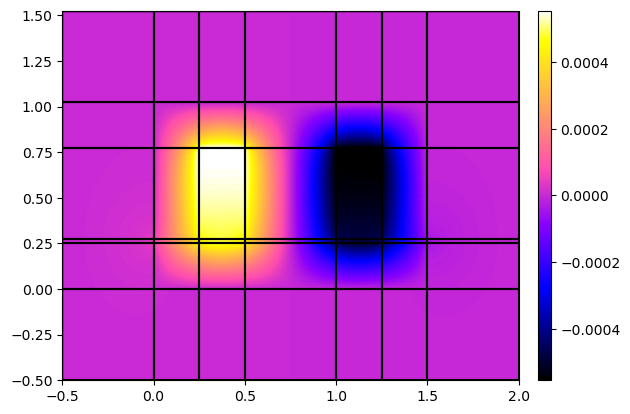

In [19]:
MP.plot(uh[-1],mesh=True, cmap='gnuplot2', contour=False)

In [20]:
def energy(MP,uh,**kwargs):
    uh_loc = MP.Basis@uh
    E=0
    for p, ((kvs, geo), _) in enumerate(MP.mesh.patches):
        uh_loc = MP.Basis@uh
        kvs0 = tuple([bspline.KnotVector(kv.mesh, 0) for kv in kvs])
        u_func = geometry.BSplineFunc(kvs, uh_loc[np.arange(MP.N[p]) + MP.N_ofs[p]])
        E += np.sum(assemble.assemble('(nu*norm(grad(uh))**2 * v) * dx', kvs=kvs0, geo=geo, nu=nu[MP.mesh.patch_domains[p]], uh=u_func,**kwargs))
    return 0.5*E*0.0254

In [21]:
energy(MP,uh[-1])

0.0008705504481933112

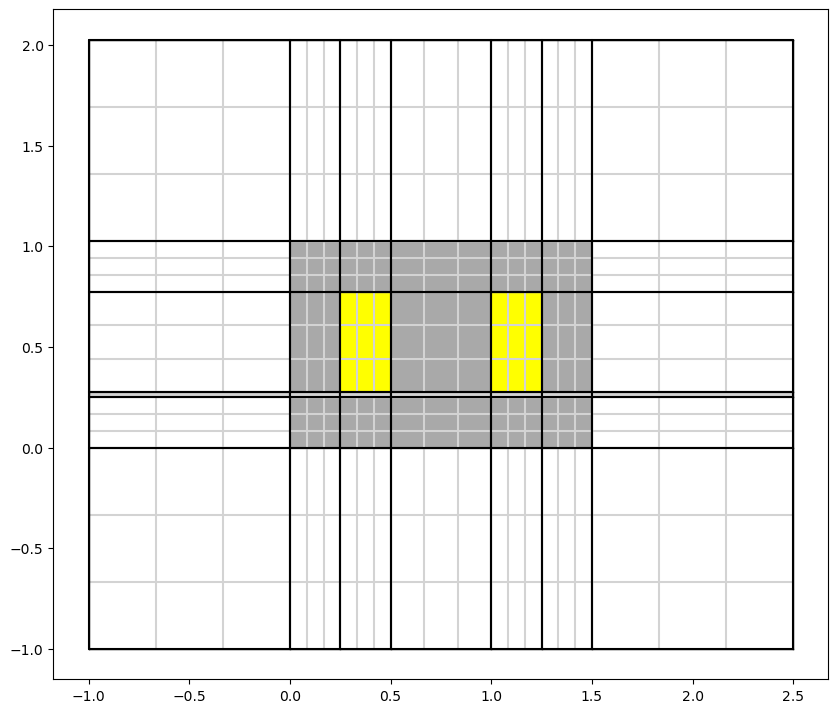

In [13]:
M.draw(knots=True, patch_idx=False, figsize=(10,10), color={'Air':'white', 'Fe':'darkgray', 'C1':'yellow', 'C2':'yellow'})

In [12]:
M.domains

{'Air': {0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19}}